# Finite dimensional linear inverse problems: A geometrical perspective
## Exercise Session 1

Created by Adam Scholefield, Michalina Pacholska, Ivan Dokmanic and Gilles Baechler

In this notebook, we will play around with some finite dimensional linear inverse problems.
Lets first import all the packages we will need.

In [1]:
# %pylab inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import signal
from scipy.fftpack import dct
from skimage import data_dir
from skimage.transform import radon, rescale
from skimage.io import imread
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

## 1-D example: ECG signal

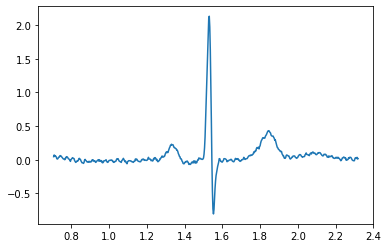

In [2]:
# read and display the ECG signal
data_ecg = np.genfromtxt('ecg.dat', delimiter=',')
x = data_ecg[:-1,1] #subtract one element to make N even
t = data_ecg[:-1,0]
N = len(x)
plt.plot(t, x)

Text(0.5, 1.0, 'Box function')

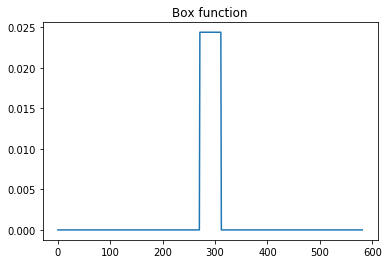

In [3]:
# create a box function
box = np.zeros(N)
box[int(N/2)-20:int(N/2)+21] = 1/41
plt.plot(box)
plt.title('Box function')

### Square convolution matrix
We are going to convolve the ECG signal ($x$) with box function ($s$). We could just use a built in convolve function but we want to write this as the matrix vector product $Ax$.

(582, 582)


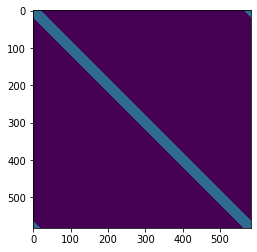

In [4]:
# Convolve the ECG signal with the box.
# We're going to creeate a matrix to do this
A = np.zeros((N, N))
for i in range(N):
    A[i:]=np.roll(box, int(i-N/2)) #assuming N is even

print(A.shape)
plt.figure(figsize=(16,4))
plt.imshow(A+0.001, interpolation='None', norm=LogNorm(vmin=0.001, vmax=10))

### Task. calculate the convolution as $y=Ax$

In [5]:
y = A @ x

Text(0.5, 1.0, 'Blurred signal')

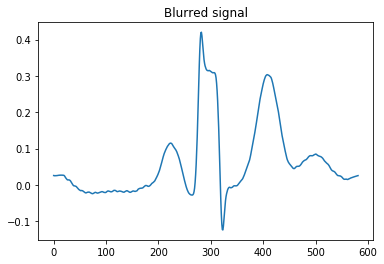

In [6]:
plt.plot(y)
plt.title('Blurred signal')

### Task. Use the inverse of $A$ to estimate $x$.

In [7]:
x_hat = np.linalg.inv(A) @ y

Lets plot the result and check that it's close to $x$

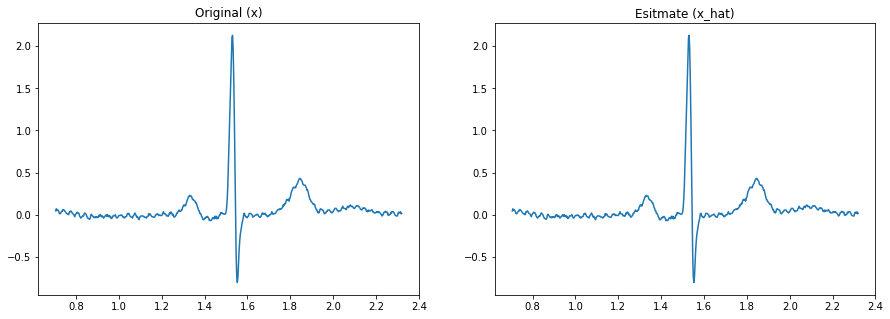

Mean squared error (MSE) is 1.646202382035226e-26


In [8]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(t,x)
ax[1].plot(t,x_hat)
ax[0].set_title('Original (x)')
ax[1].set_title('Esitmate (x_hat)')
plt.show()
print('Mean squared error (MSE) is', np.mean((x-x_hat)**2))

### Spectrum of the operator
We just blindly calculated the inverse. Whilst this worked with this blurring kernel and no noise, in general it's not a good strategy. To see this lets add a small amount of noise to $y$ and try to reconstruct.

In [9]:
# Add some noise to y
M = len(y)
y_noisy = y+2e-3*np.random.randn(M)

### Task. Try to estimate $x$ using the inverse of $A$. Plot the result and calculate the MSE.

In [10]:
x_hat = np.linalg.inv(A) @ y_noisy

We see that something has definetly gone wrong. 
To understand what has happened, lets plot the singular values of $A$.

Text(0.5, 1.0, 'Singular values of A')

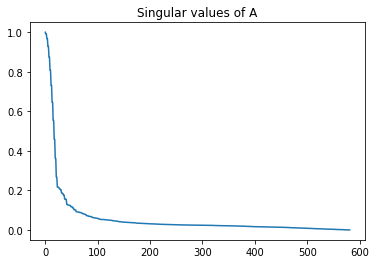

In [11]:
# plot the signular values of A
U, s, Vh = np.linalg.svd(A)
plt.plot(s)
plt.title('Singular values of A')

The singular values decay quickly but stay large enough to allow invertability in the noiseless case. However, with a small amount of noise, it breaks down.

Trimming the SVD provides a more stable way to invert into the range space of the trimmed operator. 
We know that $\boldsymbol{A}=\boldsymbol{U\Sigma V}^\top$. However, since some of the singular values are too small, lets remove them from $\boldsymbol{\Sigma}$. This will produce a new trimmed matrix, which we will call $\boldsymbol{\Sigma_T}$. In addition, we will need to trim the corresponding columns of $\boldsymbol{U}$ and $\boldsymbol{V}$.
### Task. Choose a sensible place to trim the singular values

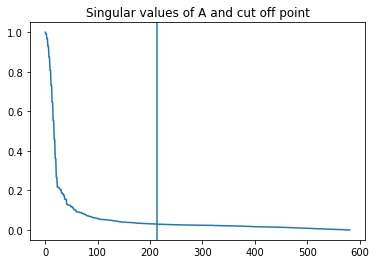

In [12]:
trim_len = sum(abs(s) > 3e-2)
plt.title('Singular values of A and cut off point')
plt.plot(s)
plt.axvline(x=trim_len)

Let's now trim the vector $\boldsymbol{s}$ and $\boldsymbol{U}$ and $\boldsymbol{V}$ matrices, producing $\boldsymbol{s_T}$ and $\boldsymbol{U_T}$ and $\boldsymbol{V_T}$. If we choose a good place to trim, we should have $\boldsymbol{A}\simeq\boldsymbol{U_T\Sigma_T V_T}^\top$.
Note that the SVD function of numpy returns the transpose of V, which we call Vh (for V Hermitian).

In [13]:
s_trimmed = s[:trim_len]
U_trimmed = U[:,:trim_len]
Vh_trimmed = Vh[:trim_len,:]
print(U_trimmed.shape)
print(Vh_trimmed.shape)

(582, 213)
(213, 582)


Lets verify that $\boldsymbol{A}\simeq\boldsymbol{U_T\Sigma_T V_T}^\top$. We will print the maximum difference of an entry (feel free to compare them in a different way).

In [14]:
print(np.max(np.abs(A-U_trimmed@np.diag(s_trimmed)@Vh_trimmed)))

0.006205811942329935


Using the SVD, the previous estimator $\hat{x}=A^T(AA^T)^{-1}y$ can be written as $\hat{x}=V\Sigma^{-1}U^T y$.

### Task. Estimate x by using the trimmed matrices to produce an approximation of this projection. Your solution should be in the range of $\boldsymbol{V_T}$.

In [15]:
x_hat = Vh_trimmed.T @ np.diag(1 / s_trimmed) @ U_trimmed.T @ y

Lets plot the result

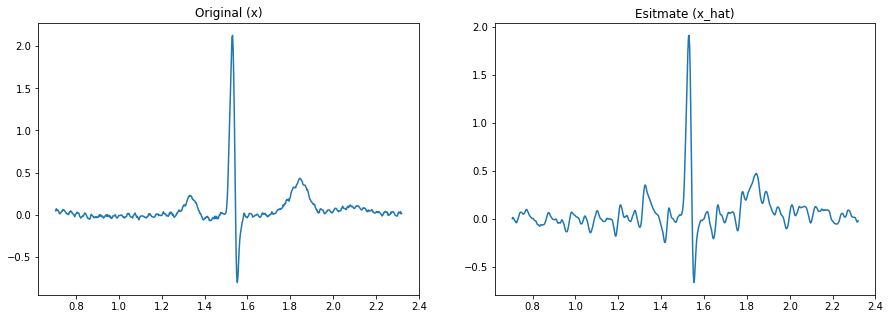

Mean squared error (MSE) is 0.004793843823963509


In [16]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(t,x)
ax[1].plot(t,x_hat)
ax[0].set_title('Original (x)')
ax[1].set_title('Esitmate (x_hat)')
plt.show()
print('Mean squared error (MSE) is', np.mean((x-x_hat)**2))

Much better.

Often, we also have to do this in the noiseless case. After the session, you can experiment with a Gaussian blur forward operator, such as below. 

**For now, just run the cell below to see the kernel. If you complete everything else, you can come back and play around with this kernel**

Text(0.5, 1.0, 'Singular values of Gaussian blur matrix')

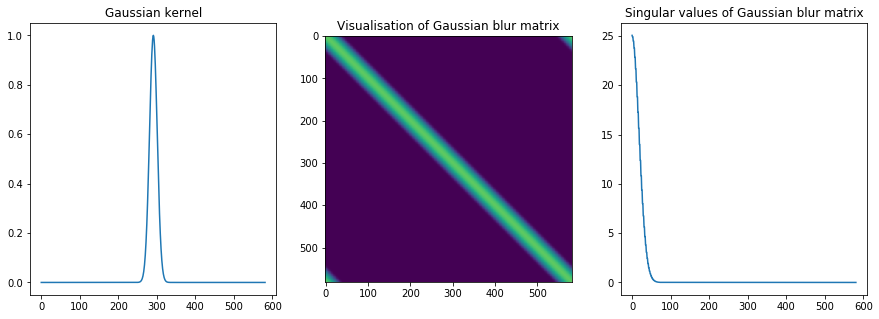

In [17]:
gaussian = signal.gaussian(N+1, std=10)
gaussian = gaussian[:N]
A_gaussian = np.zeros((N, N))
for i in range(N):
    A_gaussian[i:]=np.roll(gaussian, int(i-N/2))

U, s, Vh = np.linalg.svd(A_gaussian)
fig, ax = plt.subplots(1,3,figsize = (15,5))
ax[0].plot(gaussian)
ax[1].imshow(A_gaussian+0.001, interpolation='None', norm=LogNorm(vmin=0.001, vmax=10))
ax[2].plot(s)
ax[0].set_title('Gaussian kernel')
ax[1].set_title('Visualisation of Gaussian blur matrix')
ax[2].set_title('Singular values of Gaussian blur matrix')

For the rest of this section using the ECG signal, we will use the box function and no noise. Therefore, we do not need to worry about truncating the small singular values.

### Fat convolution matrix (downsampling)
We will now remove half the rows of A so that we have a downsampling matrix

(291, 582)


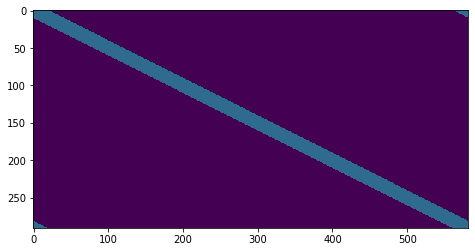

In [18]:
# Remove half the rows of A
down_sample_factor = 2
A2 = A[::down_sample_factor,:]
t2 = t[::down_sample_factor]
print(A2.shape)
plt.figure(figsize=(16,4))
plt.imshow(A2+0.001, interpolation='None', norm=LogNorm(vmin=0.001, vmax=10))

Text(0.5, 1.0, 'Blurred and downsampled signal')

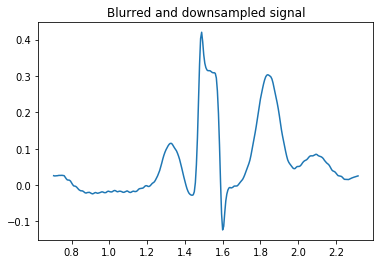

In [19]:
# Calculate the downsampled measurements
y2 = A2@x
plt.figure()
plt.plot(t2,y2)
plt.title('Blurred and downsampled signal')

### Task. Estimate $x$ using an ideally matched consistent estimator.

In [20]:
x_hat = A2.T @ np.linalg.inv(A2 @ A2.T) @ y2

Lets plot the result

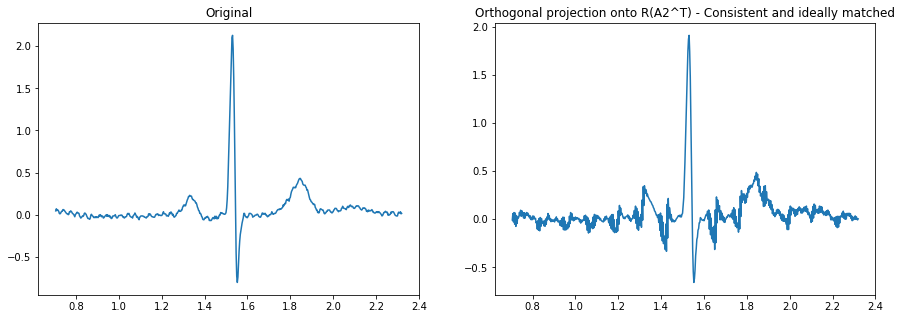

MSE is 0.004981453800344812


In [21]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(t,x)
ax[1].plot(t,x_hat)
ax[0].set_title('Original')
ax[1].set_title('Orthogonal projection onto R(A2^T) - Consistent and ideally matched')
plt.show()
print('MSE is', np.mean((x-x_hat)**2))

### Task. Verify that your estimator is consistent

In [22]:
np.any(A @ x_hat - y)

True

### Oblique projection
Suppose we believe that an ECG signal does not contain very high frequencies. We can use this prior to project onto the range space of a different operator, whilst maintaining consistency. Let's use the discrete cosine transform (DCT) matrix and keep the $M$ lowest frequencies.

In [23]:
# construct matrix B so R(B) is M lowest frequencies 
[M, N] = A2.shape
B = dct(np.eye(N)) #create an NxN DCT matrix
B = B[:,:M] #remove all cols after freq_to_keep to only keep the freq_to_keep lowest frequencies

### Task. Estimate $x$ by projecting onto the range of $B$ whilst maintaining consistency

In [24]:
x_hat = B @ np.linalg.inv(A2 @ B) @ y2

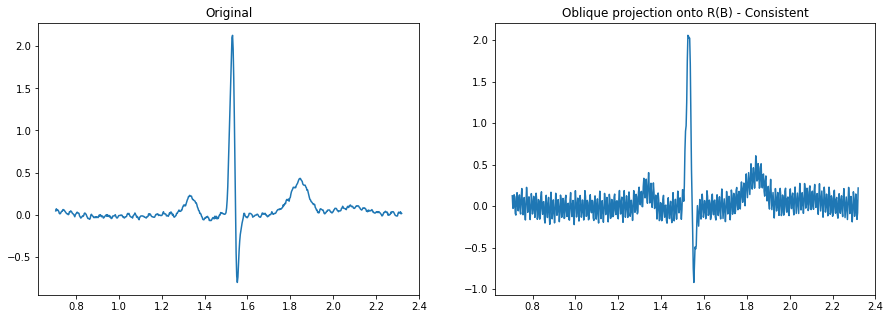

MSE is 0.012208502755272653


In [25]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(t,x)
ax[1].plot(t,np.real(x_hat))
ax[0].set_title('Original')
ax[1].set_title('Oblique projection onto R(B) - Consistent')
plt.show()
print('MSE is', np.mean((x-x_hat)**2))

So the prior has helped recover the shape but we are including too high frequencies. We chose to use the $M$ lowest frequency terms so that the matrix $AB$ was square and could be inverted. However, a better prior would be to use less frequency terms. While enforcing this prior is more complicated, it really shows the merit of the geometrical way of thinking! Since I couldn't resist including this, it appears below. It is beyond what is expected for this first session but, if you're interested, ask an instructor to explain the geometry. It's beautiful :-)

### Optional. Ask an instructor about this (you may want to complete the tomography part before looking at this)
Now we'll decrease the number of frequency components we use so that we reduce the dimension of the range space of $B$. In this case, the affine subspace of consistent solutions and the range space of $B$ will not intersect, in general. Therefore, we can either find the solution in the range space of $B$ that is closest to the affine subspace of consistent solutions or find the solution in the affine subspace of consistent solutions that is closest to the range space of $B$.

In [26]:
# we will find both the solution in R(B) that is closest to the affine subspace of consistent solutions
# and the solution in the affine subspace of consistent solutions that is closest to R(B)

freq_to_keep = 120 #half the number of frequency terms we will use
B = dct(np.eye(N)) #create an NxN DCT matrix
B = B[:,:freq_to_keep] #remove all cols after freq_to_keep to only keep the freq_to_keep lowest frequencies

U, s, Vh = np.linalg.svd(A2) #take the SVD of A2 so that we can abstract a bases for its null space
basesNullspaceA = Vh[len(s):,:].T #abstract the null space
T = np.hstack([B,-basesNullspaceA]) #concatonate a bases for B with a bases for the null space of A

coeffs = np.linalg.inv(T.T@T)@T.T@A2.T@np.linalg.inv(A2@A2.T)@y2 #solve the least squares problem (first 2*half_len coeffs are for B and the rest for the null space of A)
x_hat = B@coeffs[:freq_to_keep] # point in R(B) that is closest to affine subspace of consistent solutions
x_hat2 = basesNullspaceA@coeffs[freq_to_keep:] + A2.T@np.linalg.inv(A2@A2.T)@y2 #consistent solution closest to R(B)

Now lets plot both estimators

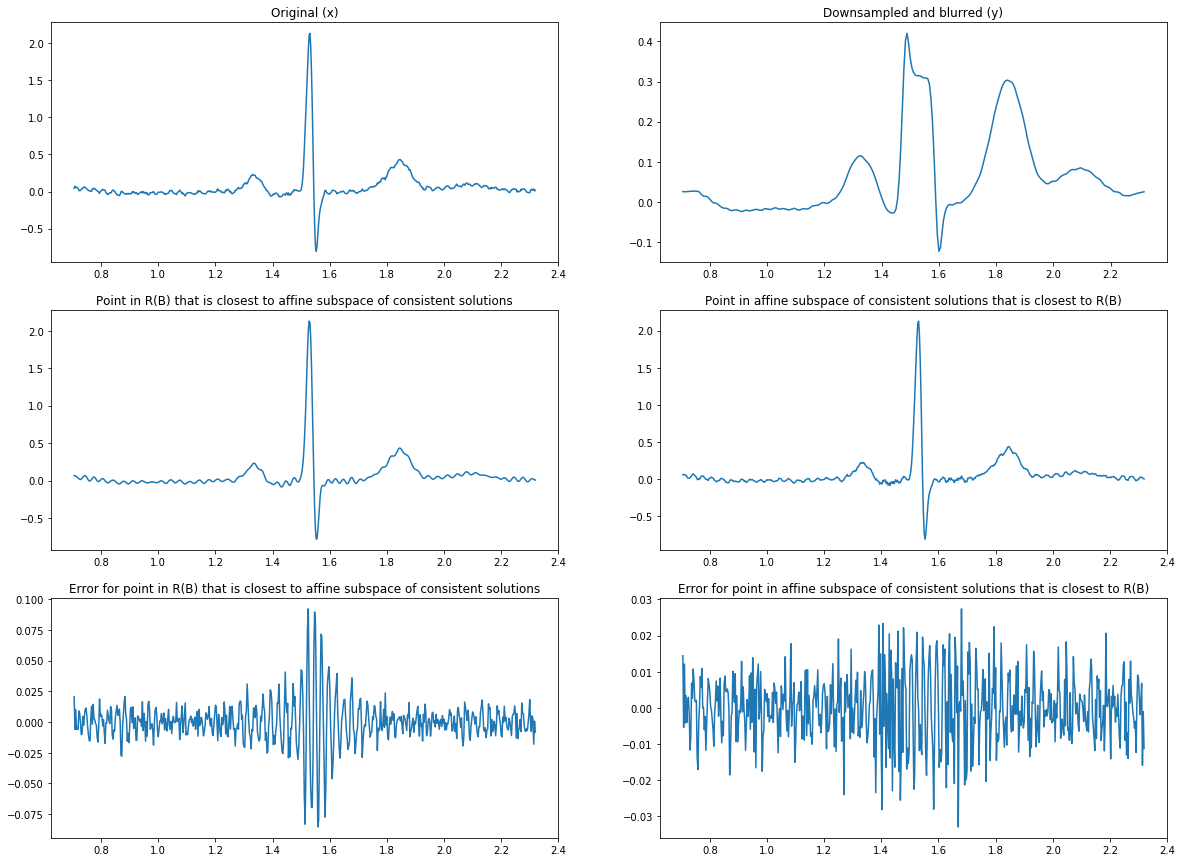

MSE for point in R(B) that is closest to affine subspace of consistent solutions is 0.00030446684211333635
MSE for point in affine subspace of consistent solutions that is closest to R(B) is 8.481619414463346e-05


In [27]:
fig, ax = plt.subplots(3,2,figsize = (20,15))
ax[0][0].plot(t,x)
ax[0][1].plot(t2,y2)
ax[0][0].set_title('Original (x)')
ax[0][1].set_title('Downsampled and blurred (y)')
ax[1][0].plot(t,x_hat)
ax[1][1].plot(t,np.real(x_hat2))
ax[1][0].set_title('Point in R(B) that is closest to affine subspace of consistent solutions')
ax[1][1].set_title('Point in affine subspace of consistent solutions that is closest to R(B)')
ax[2][0].plot(t,np.real(x_hat)-x)
ax[2][1].plot(t,np.real(x_hat2)-x)
ax[2][0].set_title('Error for point in R(B) that is closest to affine subspace of consistent solutions')
ax[2][1].set_title('Error for point in affine subspace of consistent solutions that is closest to R(B)')
plt.show()
print('MSE for point in R(B) that is closest to affine subspace of consistent solutions is', np.mean((x-x_hat)**2))
print('MSE for point in affine subspace of consistent solutions that is closest to R(B) is', np.mean((x-x_hat2)**2))

If you want, you can verify if the estimators are consistent.

## Tomography example (in 2D)
Let's now look at a 2D version of tomography.

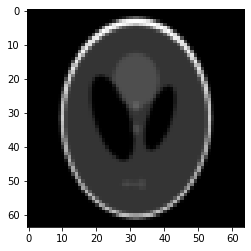

In [28]:
# let's first load an image
N = 64
image = imread(data_dir + "/phantom.png", as_gray=True)
image = rescale(image, (N / image.shape[0], N / image.shape[1]), mode='constant', multichannel = False)

plt.imshow(image, interpolation='None')
plt.gray()

As explained in class, in X-ray tomography, x-rays are fired through the object at different angles and the transmission is measured at the other side. To simulate these measurements, we want to be able to compute integrals at different angles. For example, it is very easy to do this horizontally and vertically by just summing the pixels.

Text(0.5, 1.0, 'Sum of rows')

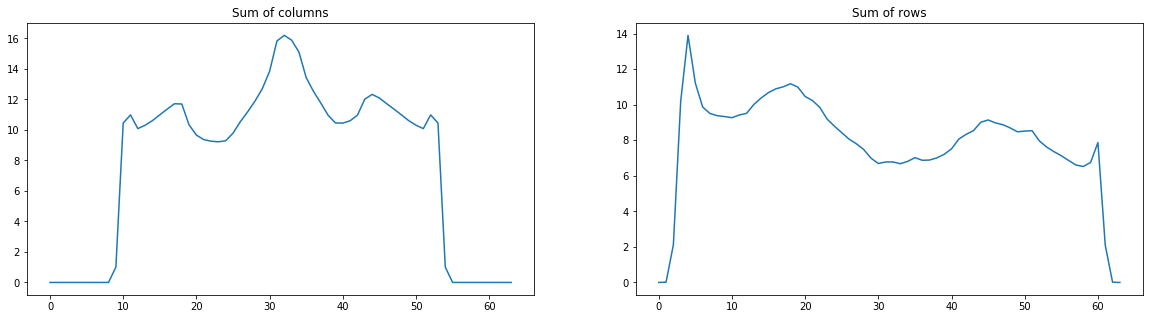

In [29]:
# lets sum the columns to give the projection for x-rays fired vertically
# and sum the rows to give the projection for x-rays fired horizontally
fig, ax = plt.subplots(1,2,figsize = (20,5))
ax[0].plot(np.sum(image,0))
ax[1].plot(np.sum(image,1))
ax[0].set_title('Sum of columns')
ax[1].set_title('Sum of rows')

We want to do this at different angles and to concatenate the resulting 1-D signals. Later in the class, this will be formalised using the **Radon transform**. For now, let's just continue without this machinery.

In [30]:
# Lets vectorise the image into a vector x
x = image.reshape(N*N)
print(x.shape)

(4096,)


### Task. Create a matrix $A$ which, when multiplied by the vectorised image, produces the sum of the columns

In [31]:
A = np.zeros((N, N*N))
for i in range(N):
    A[i, [i + j*64 for j in range(64)]] = 1

The dimensions of A are (64, 4096)


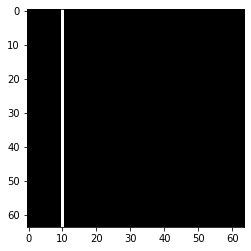

In [32]:
# Let visualise a few rows from A (change the value of row and check things make sense)
print('The dimensions of A are',A.shape)
row = 10
plt.imshow(A[row,:].reshape(N,N))

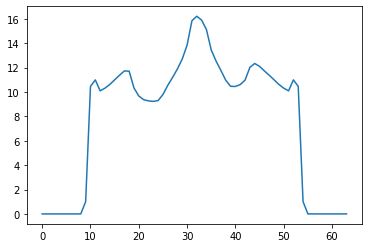

In [33]:
# And we can recalculate the sum of the columns using A (we should get the same as we did before)
plt.plot(A@x)

### Task. Add rows to the bottom of $A$ to sum the rows

In [34]:
A_row = np.zeros((N, N*N))
for i in range(N):
    A_row[i, i*64:(i+1)*64] = 1

The dimensions of A are (64, 4096)


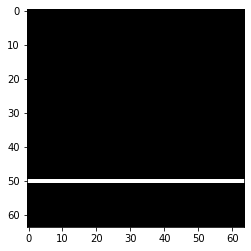

In [35]:
# We can now visualise any of the rows of the larger A
print('The dimensions of A are',A_row.shape)
row = 50
plt.imshow(A_row[row,:].reshape(N,N))

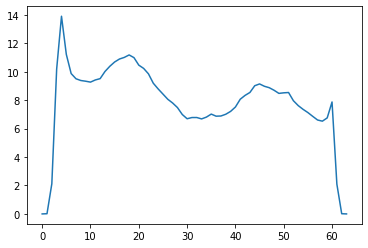

In [36]:
# And we can recalculate the sum of the rows using A_row (we should get the same as we did before)
plt.plot(A_row@x)

It should now be clear that we want to continue to add rows to $A$ but with lines taken at different angles. The following function calculates a matrix $A$ with a certain number of projection directions.

In [37]:
def calcTomographyForwardOperator(numAngles, N):
    theta = np.linspace(0, 180, numAngles, endpoint = False)
    A = []
    E = np.zeros((N, N))
    for i_y in tqdm(range(N)):
        for i_x in range(N):
            E[i_y, i_x] = 1
            R_E = radon(E, theta=theta, circle=False)
            E[i_y, i_x] = 0
            A.append(R_E.flatten())
            
    return np.array(A).T

In [38]:
# calculate the forward operator
A = calcTomographyForwardOperator(20, N)

(1820, 4096)


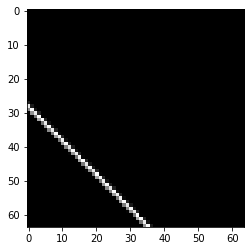

In [39]:
# visualise a row
print(A.shape)
row = 505
plt.imshow(A[row,:].reshape(N,N))

Notice that $A$ is a fat matrix.

In [40]:
# lets calculate our measurements
y=A@x

### Task. Before we use a right inverse, estimate $x$ using $A^\top$. Plot the resulting image.

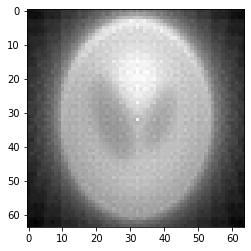

In [41]:
x_hat = A.T @ y
plt.imshow(x_hat.reshape(N, N), interpolation='None')
plt.gray()

It's not great but we see something. This reconstruction is known as the backprojection solution. You'll learn about this more when you study tomography.

### Task. Estimate $x$ using a right inverse (or an approximation of one): you may need to remove small singular values. Plot the resulting image.

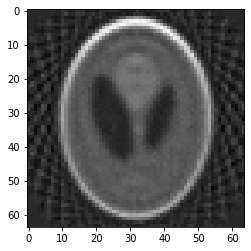

In [42]:
x_hat = A.T @ np.linalg.pinv(A @ A.T) @ y
plt.imshow(x_hat.reshape(N, N), interpolation='None')
plt.gray()

This is much better than the estimate from back projection. Let's quickly check that it is consistent.

In [43]:
# Mean squared error (MSE) between y and A@x_hat
print(np.mean((y - A@x_hat)**2))

2.6731339489217145e-15


### Task. Repeat as above but with 50 angles. Verify that you get a tall matrix. 

In [44]:
A = calcTomographyForwardOperator(50, N)

Lets calculate the measurements

In [45]:
y=A@x

### Task. Calculate the backprojection estimate. Plot the resulting image.

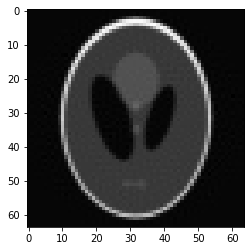

In [46]:
x_hat = A.T @ np.linalg.pinv(A @ A.T) @ y
plt.imshow(x_hat.reshape(N, N), interpolation='None')
plt.gray()

### Task. Use a left-inverse (or an approximation of one) to estimate $x$. Plot the resulting image.

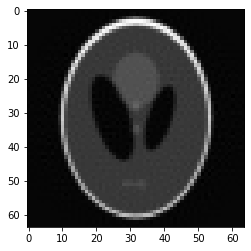

In [47]:
x_hat = np.linalg.pinv(A.T @ A) @ A.T @ y
plt.imshow(x_hat.reshape(N, N), interpolation='None')
plt.gray()

That's it for now. However, you can imagine how using priors for the tomography example could also help the reconstruction. In particular, with well chosen priors, we should be able to use less angles and still achieve a good reconstruction. In practice, this means less x-rays passing through the object (people in the medical scenario) and quicker acquisitions (cheaper).

Later in class, we will come back to the tomography example. By then, we will know how to switch between general Hilbert spaces and so we will be able to use more elaborate tools.